[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.9.7. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

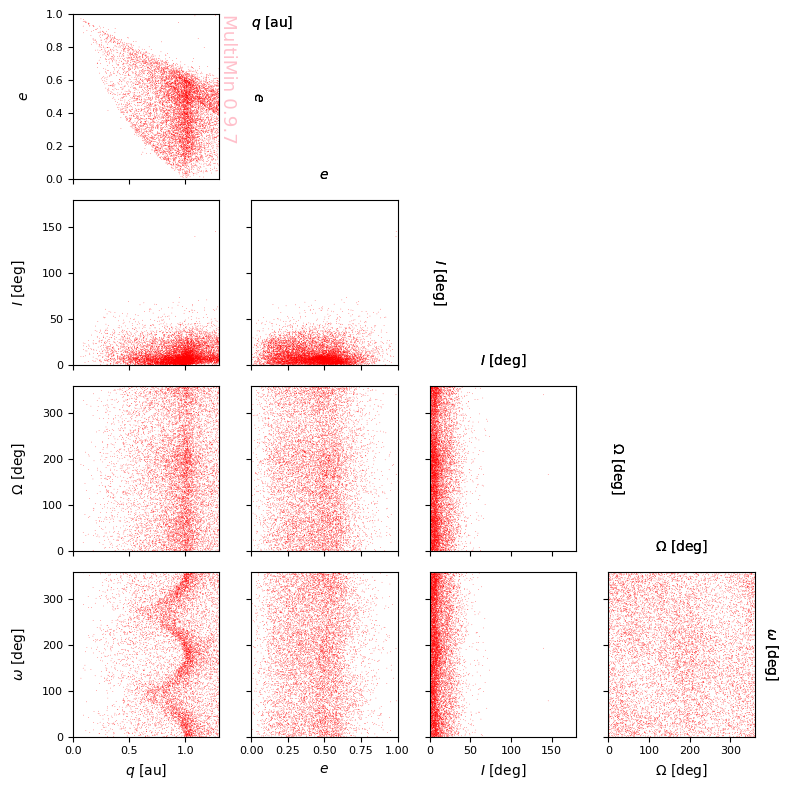

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

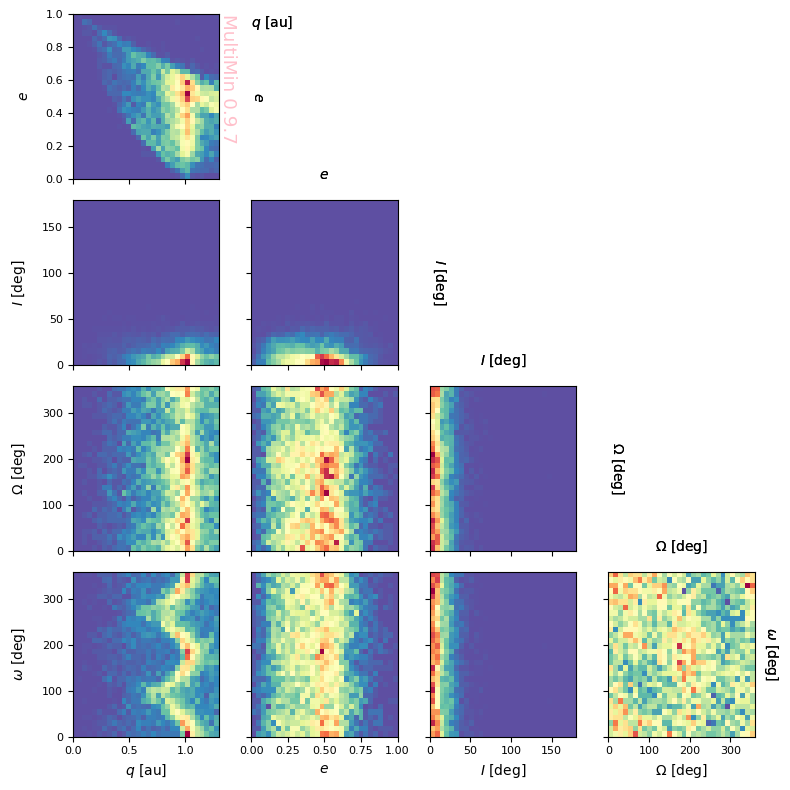

In [5]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

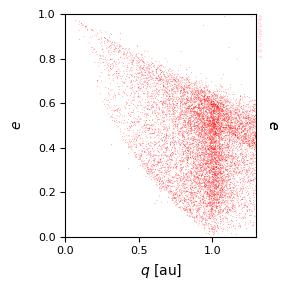

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitCMND(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.309428811570143
Elapsed time since last call: 109.142 ms
-log(L)/N = -0.5354287303761275


And check the fit result:

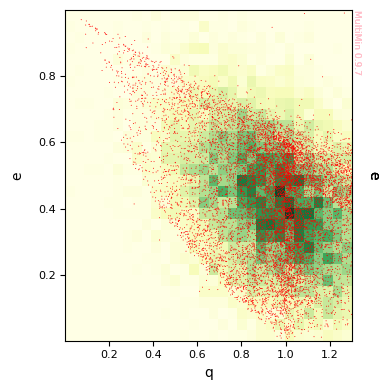

In [9]:
# properties: list of names or dict like DensityPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.cmnd.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.97875,0.410222,0.271263,0.191117,-0.446085


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitCMND(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data()
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitCMND object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.2482063080519733


Elapsed time since last call: 21.0569 s
-log(L)/N = -0.7144460138169938


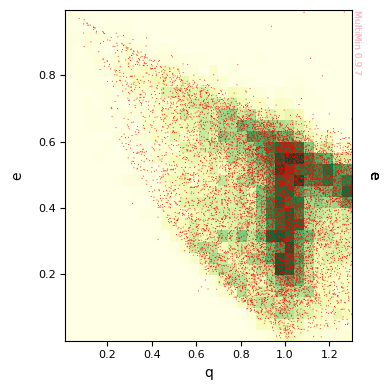

In [12]:
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.cmnd.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

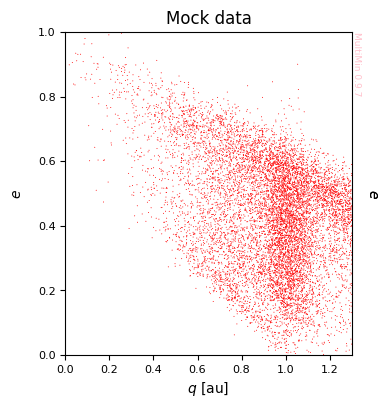

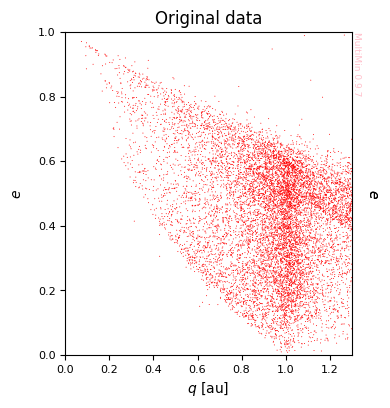

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.cmnd.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
2,0.298896,1.299221,0.463564,0.468916,0.175558,-0.954674
5,0.268025,0.957485,0.437433,0.282504,0.139021,-0.766178
3,0.223404,1.004289,0.345572,0.059732,0.155696,-0.067650
4,0.159521,0.873853,0.263634,0.236431,0.126107,-0.842456
1,0.050154,0.753167,0.193915,0.142728,0.094728,-0.950651


In [16]:
function, cmnd = F.cmnd.get_function(properties=properties)

import numpy as np
from multimin import tnmd

def cmnd(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.753167
    mu1_e = 0.193915
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.020371, -0.012853], [-0.012853, 0.008973]]
    Z1 = 0.979674
    n1 = tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 1.299221
    mu2_e = 0.463564
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.219882, -0.078591], [-0.078591, 0.030821]]
    Z2 = 0.497716
    n2 = tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 1.004289
    mu3_e = 0.345572
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.003568, -0.000629], [-0.000629, 0.024241]]
    Z3 = 0.986761
    n3 = tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 0.873853
    mu4_e = 0.263634
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.0559, -0.025118], [-0.025118, 0.015903]]
    Z4 = 0.958003
    n4 = tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 0.957485
    mu5_e = 0.437433
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.079809, -0.030091], [-0.030091, 0.019327]]
    Z5 = 0.886945
    n5

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 135.1312410535071
-log(L)/N = 3.4856503669193453


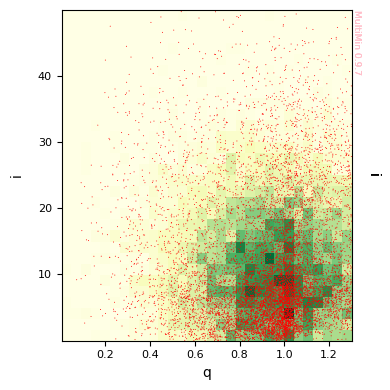

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitCMND(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 137.95909529616677
-log(L)/N = 3.3152592248988046


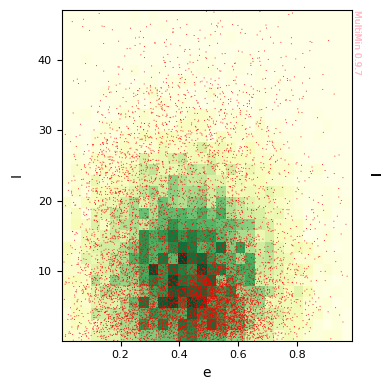

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitCMND(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

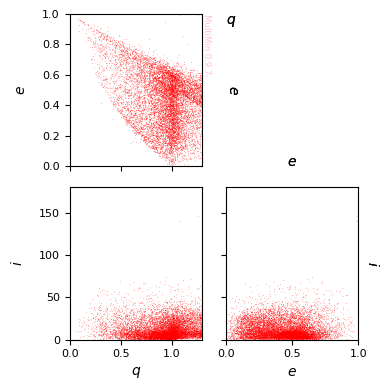

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 148.37455201369957


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -1.4347015480391176


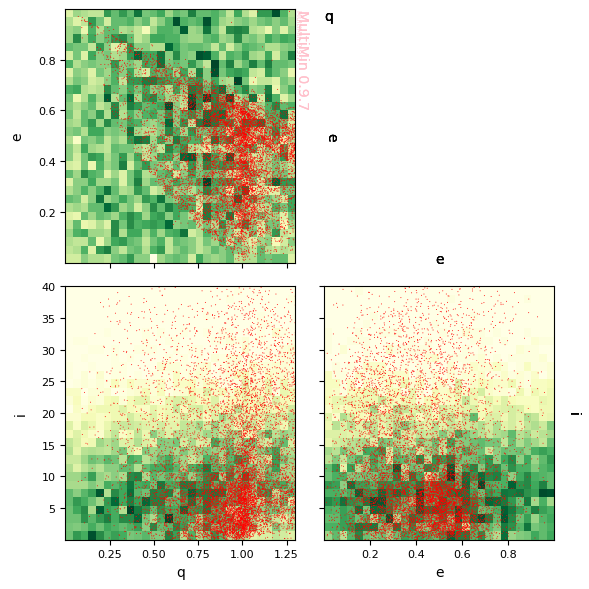

In [21]:
fit_qei = mn.FitCMND(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 148.37455216717905


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -2.359571203421599


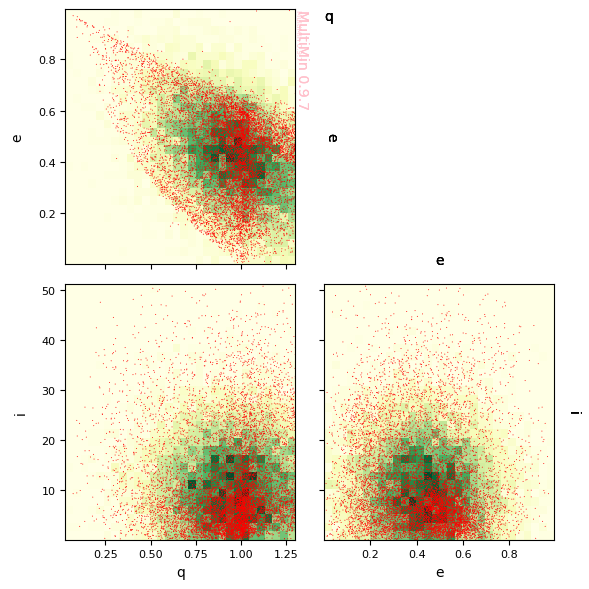

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.cmnd.mus[0, 0] + F_qi_1.cmnd.mus[0, 0]) / 2
mu_e = (F_qe_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 0]) / 2
mu_i = (F_qi_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 1]) / 2
sigma_q = (F_qe_1.cmnd.sigmas[0, 0] + F_qi_1.cmnd.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.cmnd.rhos[0, 0])
rho_qi = float(F_qi_1.cmnd.rhos[0, 0])
rho_ei = float(F_ei_1.cmnd.rhos[0, 0])

fit_qei = mn.FitCMND(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitCMND object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 332.92773106407867


Minimizing: 0it [00:00, ?it/s]

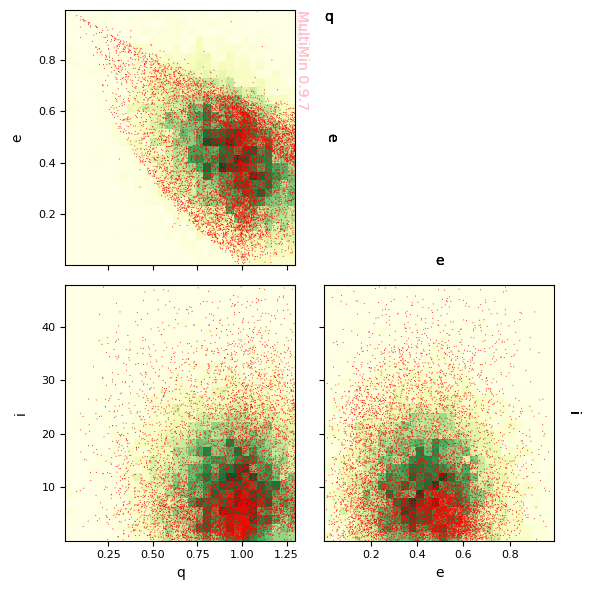

In [23]:
fit_qei = mn.FitCMND(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the CMND is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the CMND in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

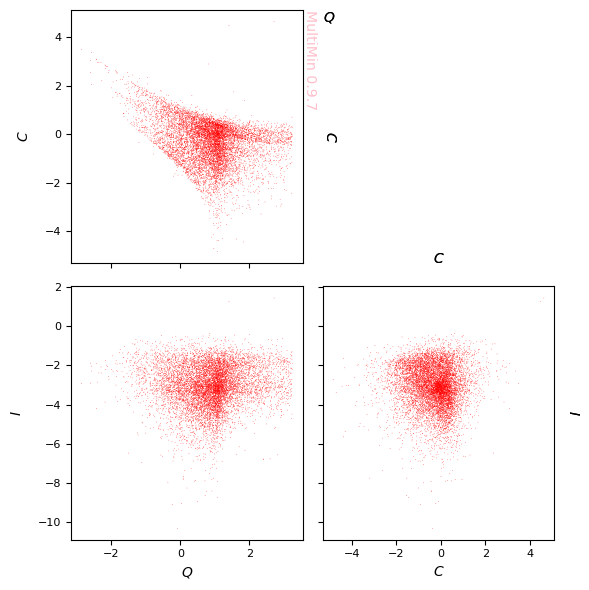

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

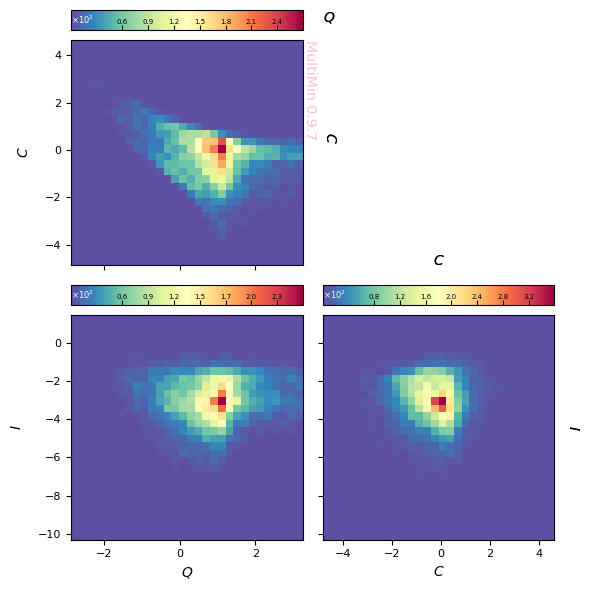

In [26]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitCMND(data=udata, ngauss=1)

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.972792607850261


The fitter holds an initial CMND that will be optimized:

In [28]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 144.963 ms
-log(L)/N = 3.9977796058601176


Inspect the fitted CMND:

In [30]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8716302335617171, -0.3366249795778732, -3.0512306262603013]]
    Standard deviations (σ): [[0.8649188785571931, 0.8756451818847102, 1.0805837269346366]]
    Correlation coefficients (ρ): [[-0.32319456124020485, 0.04842984619021151, -0.0624576167773464]]

    Covariant matrices (Σ): 
        [[[0.7480846664846325, -0.24477529503918866, 0.0452633704045877], [-0.24477529503918866, 0.7667544845579072, -0.05909789254053549], [0.0452633704045877, -0.05909789254053549, 1.167661190915949]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8716302335617171, -0.3366249795778732, -3.0512306262603013, 0.7480846664846325, -0.24477529503918866, 0.0452633704045877, 0.7667544845579072, -0.05909789254053549, 1.167661190915949]
        With std. and correlati

Plot the fit result (fitted sample + data scatter):

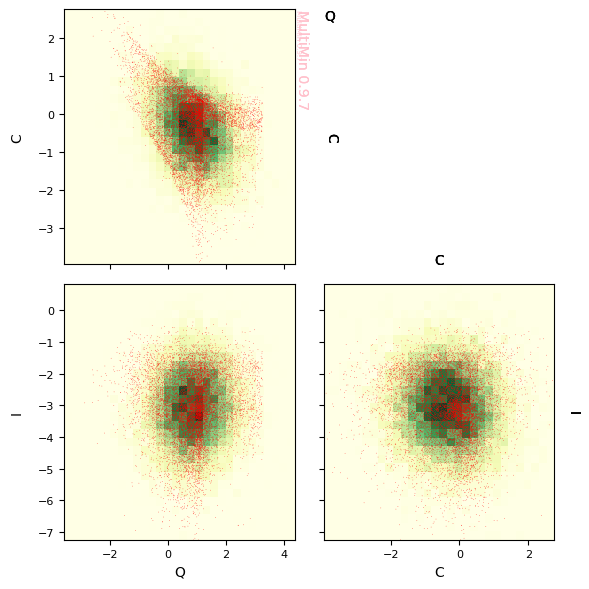

In [31]:
properties=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitCMND(f"gallery/{figprefix}_fit-single.pkl")
print(F.cmnd)

Loading a FitCMND object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.9977796058601176
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8716302335617171, -0.3366249795778732, -3.0512306262603013]]
    Standard deviations (σ): [[0.8649188785571931, 0.8756451818847102, 1.0805837269346366]]
    Correlation coefficients (ρ): [[-0.32319456124020485, 0.04842984619021151, -0.0624576167773464]]

    Covariant matrices (Σ): 
        [[[0.7480846664846325, -0.24477529503918866, 0.0452633704045877], [-0.24477529503918866, 0.7667544845579072, -0.05909789254053549], [0.0452633704045877, -0.05909789254053549, 1.167661190915949]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8716302335617171, -0.3366249795778732

Fit with two Gaussian components for a better likelihood:

Loading a FitCMND object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.972792607850261


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 726.439 ms
-log(L)/N = 3.907835278139035
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.29047170646181825, 0.7095282935381818]
    Number of variables: 3
    Averages (μ): [[0.354661604468379, 0.39752111237452065, -3.4585978623385234], [1.0669817451337649, -0.6217984220980496, -2.8928391368301853]]
    Standard deviations (σ): [[0.8376138406198528, 0.6034503273851866, 1.272127095742884], [0.7904948945317256, 0.7921219485497926, 0.9464827919454659]]
    Correlation coefficients (ρ): [[-0.7235632558215968, -0.35892916889475457, 0.31383620379889043], [0.01970126664173888, 0.13455700705462692, -0.015019600102432975]]

    Covariant matrices (Σ): 
        [[[0.7015969459979401, -0.36573108676316424, -0.38245742903580465], [-0.36573108676316424, 0.3641522976212888, 0.2409212301994513], [-0.38245742903580465, 0.2409212301994513, 1.618307347723225]], [[0.624882178280724, 0.012336309747625621, 0.10067418218757408], [

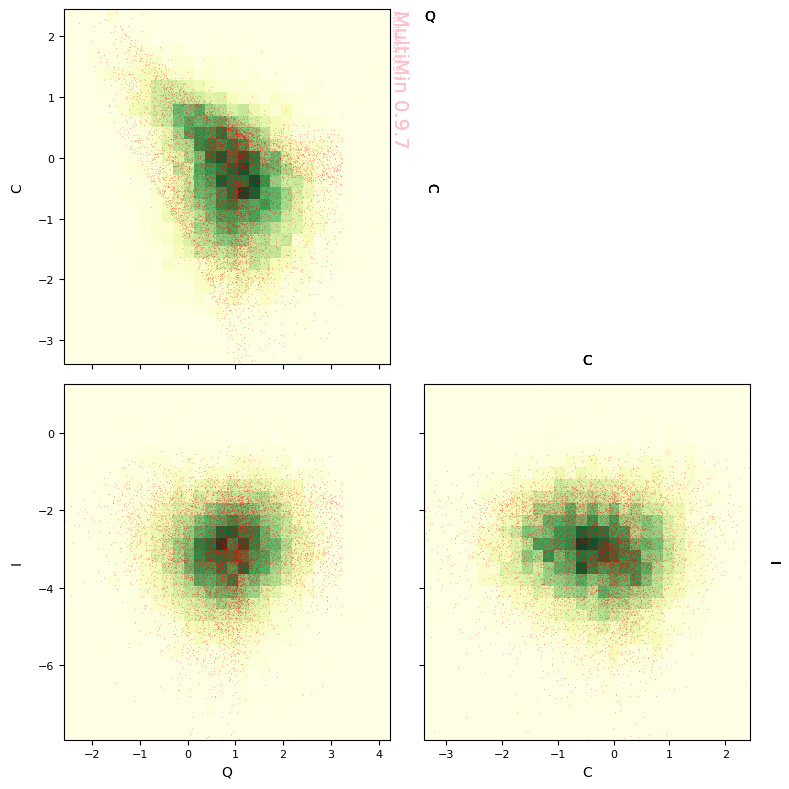

In [34]:
F=mn.FitCMND(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitCMND object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.972792607850261


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 778.141 ms
-log(L)/N = 3.907838383428371
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.2893591455070618, 0.7106408544929382]
    Number of variables: 3
    Averages (μ): [[0.3528637288831984, 0.3997800568031747, -3.4589432855691986], [1.0662064674956557, -0.6208847311772919, -2.893518298980567]]
    Standard deviations (σ): [[0.8375061567804282, 0.6030899653341212, 1.27253097310291], [0.7906743743616007, 0.7920015645491704, 0.946939837027462]]
    Correlation coefficients (ρ): [[-0.7248241598664684, -0.3598486074707743, 0.31488765206774927], [0.01881105091540869, 0.13426716046291265, -0.01520530733880665]]

    Covariant matrices (Σ): 
        [[[0.7014165626451231, -0.3661025649511798, -0.3835095619100535], [-0.3661025649511798, 0.3637175062867115, 0.2416607365485907], [-0.3835095619100535, 0.2416607365485907, 1.619335077506239]], [[0.6251659662721087, 0.011779768673781513, 0.10052865113460535], [0.0117797

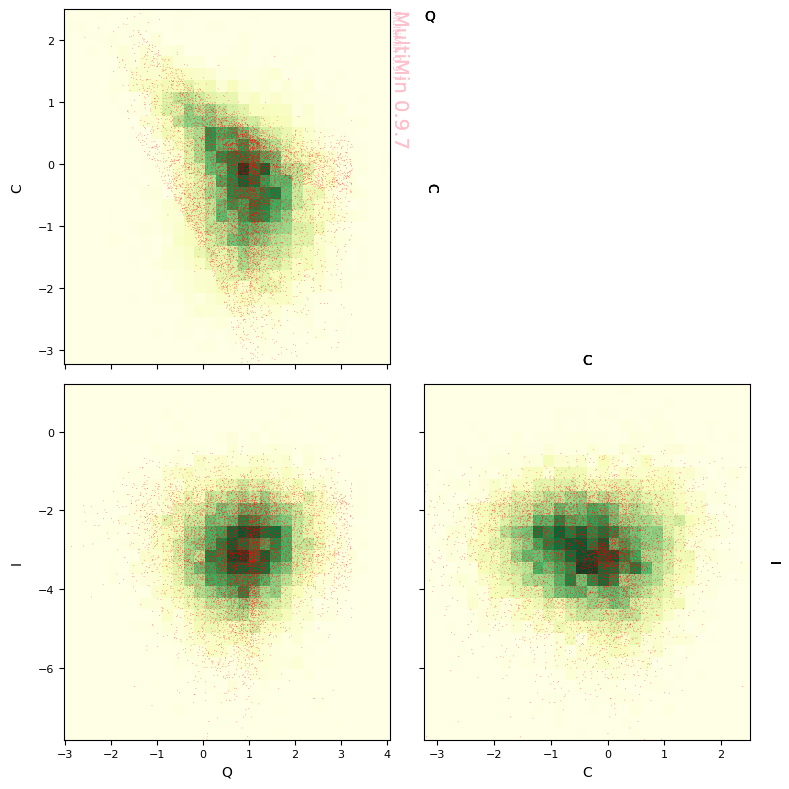

In [35]:
F=mn.FitCMND(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitCMND object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.972792607850261


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 6.19195 s
-log(L)/N = 3.760670610752643
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.09009512593553935, 0.21524092956439322, 0.2017475051291479, 0.2210982977365281, 0.27181814163439133]
    Number of variables: 3
    Averages (μ): [[0.320465440955665, 0.7013451627110739, -3.727623703022537], [1.627110181226462, -0.3783174535300161, -2.7607367374490894], [0.999632329051355, 0.1557248868214983, -3.4046216466771106], [0.15941884879932003, -0.537236569971141, -2.431782741054821], [0.9039778195628768, -0.8085473834110734, -3.3221661943393825]]
    Standard deviations (σ): [[0.7039671704230337, 0.393066143345212, 1.2642095087019756], [0.8353713087413467, 0.4448760698209485, 0.8056061169463957], [0.432112091138833, 0.2577158516177486, 0.8597448042365988], [0.8263427350241078, 1.2012801526981862, 0.725484577175549], [0.600311000515317, 0.7751668333887878, 1.259449891842844]]
    Correlation coefficients (ρ): [[-0.

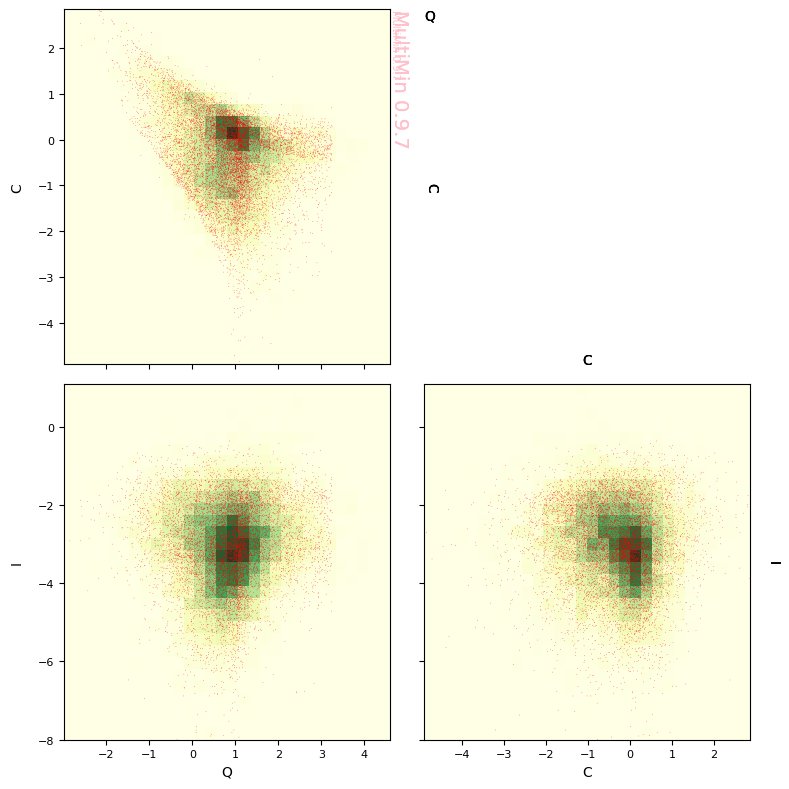

In [36]:
F=mn.FitCMND(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

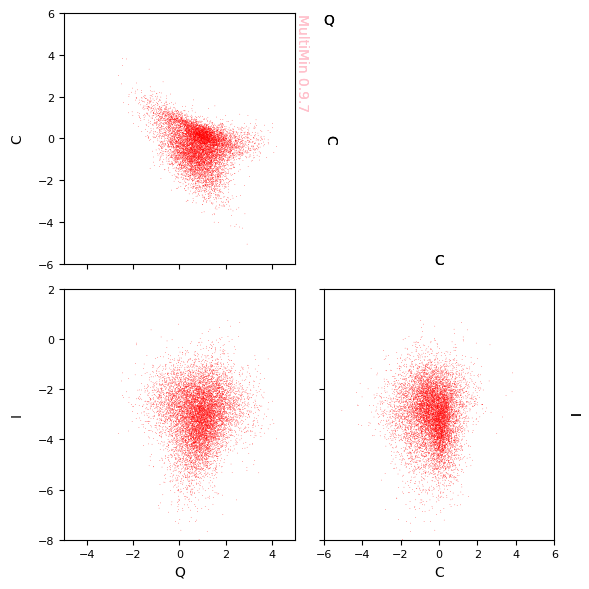

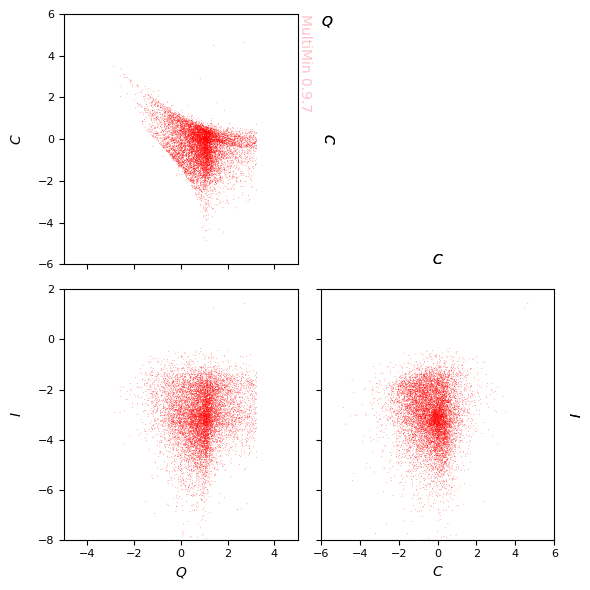

In [37]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

We can also check the original distribution:

In [38]:
scales=[1.35,1.00,180.0]
usample = F.cmnd.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

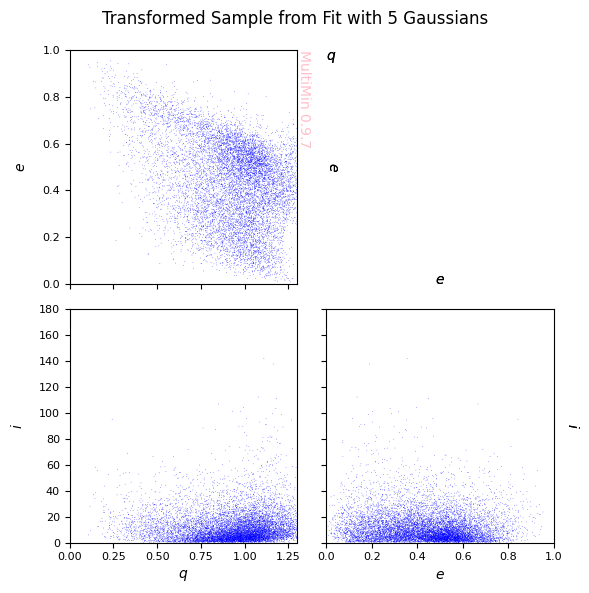

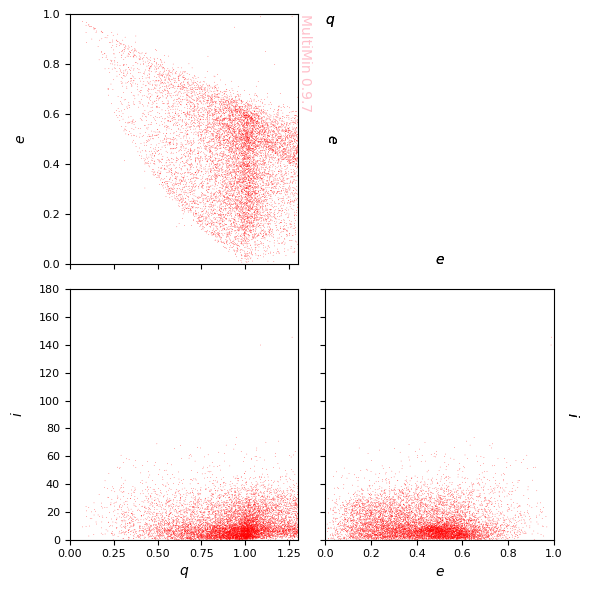

In [39]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.scatter_plot(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.scatter_plot(data_neas_qei,**sargs)

In [40]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_q = 0.320465
    mu1_e = 0.701345
    mu1_i = -3.727624
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.49557, -0.243466, -0.293498], [-0.243466, 0.154501, 0.175402], [-0.293498, 0.175402, 1.598226]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_q = 1.62711
    mu2_e = -0.378317
    mu2_i = -2.760737
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.697845, 0.081662, 0.018236], [0.081662, 0.197915, -0.040617], [0.018236, -0.040617, 0.649001]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_q = 0.999632
    mu3_e = 0.155725
    mu3_i = -3.404622
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.186721, -0.030932, 0.066777], [-0.030932, 0.066417, 0.054433], [0.066777, 0.054433, 0.739161]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_q = 0.159419
    mu4_e = -0.537237
    mu4_i = -2.431783
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.682842, -0.795089, 0.003068], [-0.795089, 1.443074, 0.096264], [0.003068, 0.096264, 0.526328]]
    n4 = nmd(X, mu4, Sigma4)

    mu

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga